In [12]:
# Importación de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Carga y unión de los datos
Los datos de características químicas vienen en *wine-data.csv* y las etiquetas de cultivo en *wine-segments.csv*.

In [2]:
# Ajustar la ruta si ejecutas desde otra carpeta
X_df = pd.read_csv('wine-data.csv')
y_df = pd.read_csv('wine-segments.csv')

print('Shape X:', X_df.shape)
print('Shape y:', y_df.shape)

df = X_df.copy()
df['Cultivar'] = y_df['Cultivar']
df.head()

Shape X: (178, 13)
Shape y: (178, 1)


,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Cultivar
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


## Análisis exploratorio de los datos (EDA)

In [3]:
# Información general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float64
 12  Proline               178 non-null    int64  
 13  Cultivar              178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


In [4]:
# Estadísticos descriptivos de las variables numéricas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
Malic_Acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
Ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
Ash_Alcanity,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
Magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
Total_Phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
Flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
Nonflavanoid_Phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
Proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58
Color_Intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00


Cultivar
1    59
2    71
3    48
Name: count, dtype: int64


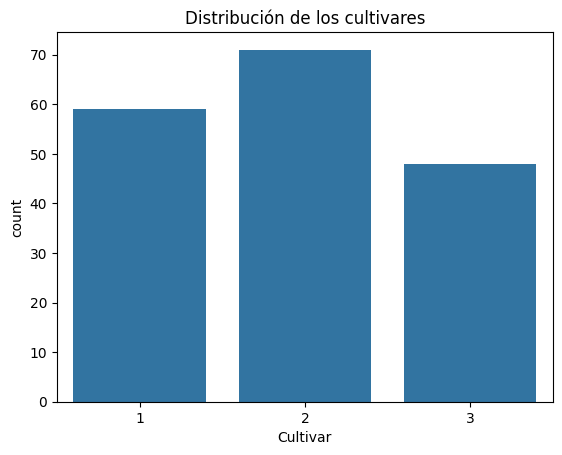

In [5]:
# Distribución de la variable objetivo (Cultivar)
cult_counts = df['Cultivar'].value_counts().sort_index()
print(cult_counts)

sns.countplot(data=df, x='Cultivar')
plt.title('Distribución de los cultivares')
plt.show()

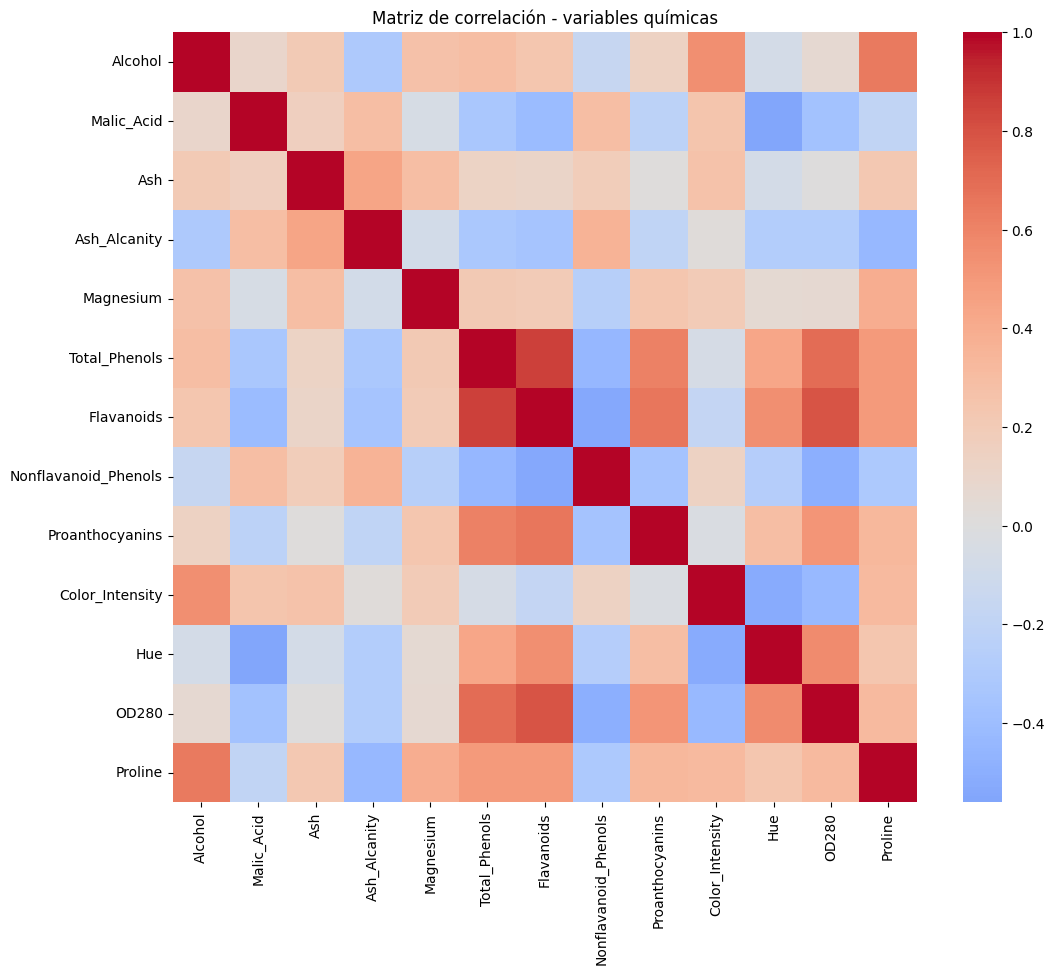

In [6]:
# Matriz de correlación de las variables químicas
plt.figure(figsize=(12, 10))
sns.heatmap(df.drop(columns=['Cultivar']).corr(), cmap='coolwarm', center=0)
plt.title('Matriz de correlación - variables químicas')
plt.show()

## Preparación de datos para modelado
Separamos variables predictoras (X) y la variable objetivo (y), y luego dividimos en entrenamiento y prueba.

In [15]:
X = df.drop(columns=['Cultivar'])
y = df['Cultivar']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Adjust y_train and y_test to be 0-indexed for XGBoost
y_train = y_train - 1
y_test = y_test - 1

X_train.shape, X_test.shape

((142, 13), (36, 13))

## Entrenamiento con distintos modelos de Boosting
Probamos al menos dos modelos de boosting: **Gradient Boosting** y **AdaBoost**.
Se evalúan mediante validación cruzada sobre el conjunto de entrenamiento.

In [20]:
models = {
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'xgboost': XGBClassifier(random_state=42)
}

results = []
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    results.append({
        'Modelo': name,
        'Accuracy_promedio': scores.mean(),
        'Accuracy_std': scores.std()
    })

pd.DataFrame(results)

,Modelo,Accuracy_promedio,Accuracy_std
0,GradientBoosting,0.958374,0.040174
1,AdaBoost,0.964778,0.039128
2,xgboost,0.944335,0.051750


## Ajuste de hiperparámetros con GridSearchCV (Gradient Boosting)
Se optimizan hiperparámetros clave como `n_estimators`, `learning_rate` y `max_depth` para el modelo de Gradient Boosting.

In [17]:
gb_clf = GradientBoostingClassifier(random_state=42)

param_grid = {
    'n_estimators': [60, 120, 250],
    'learning_rate': [0.03, 0.15, 0.35],
    'max_depth': [2, 3, 4]
}

grid_search = GridSearchCV(
    estimator=gb_clf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print('Mejores hiperparámetros:', grid_search.best_params_)
print('Mejor accuracy (CV):', grid_search.best_score_)

Mejores hiperparámetros: {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 120}
Mejor accuracy (CV): 0.9721674876847292


## Evaluación del mejor modelo en el conjunto de prueba

Accuracy en test: 1.0
Reporte de clasificación:               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



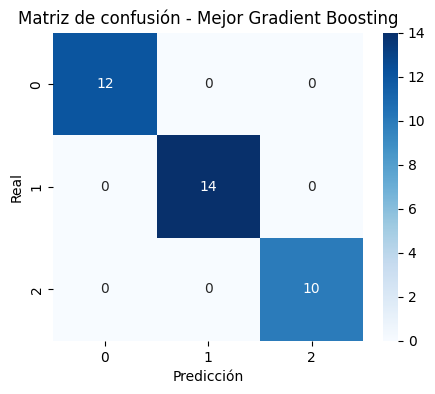

In [18]:
best_model = grid_search.best_estimator_

y_pred_test = best_model.predict(X_test)

print('Accuracy en test:', accuracy_score(y_test, y_pred_test))
print('Reporte de clasificación:', classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión - Mejor Gradient Boosting')
plt.show()

## Comparación final y conclusiones
- Revise la tabla de resultados de validación cruzada para comparar Gradient Boosting vs AdaBoost.
- Compare esas métricas con el desempeño del mejor modelo optimizado en el conjunto de prueba.
- Analice si hay sobreajuste (CV vs test) y qué tan bien distingue entre los 3 cultivares.

##Resultados de Validación Cruzada:


---


|index|Modelo|Accuracy\_promedio|Accuracy\_std|
|---|---|---|---|
|0|GradientBoosting|0\.9583743842364532|0\.04017421838148233|
|1|AdaBoost|0\.9647783251231526|0\.03912769151194203|
|2|xgboost|0\.9443349753694582|0\.0517499349228331|

---
**Análisis de los Resultados:**

AdaBoost muestra el mejor rendimiento promedio en la validación cruzada, con una precisión de aproximadamente 96.48%. Además, su desviación estándar es la más baja, lo que indica una mayor consistencia en su rendimiento.


Gradient Boosting está muy cerca de AdaBoost, con una precisión promedio de aproximadamente 95.84% y una desviación estándar similar.


XGBoost tiene la precisión promedio más baja de los tres, aproximadamente 94.43%, y la desviación estándar más alta, lo que sugiere que su rendimiento puede ser un poco más variable entre los diferentes pliegues de validación cruzada.


Basado en estos resultados, AdaBoost parece ser el modelo con el rendimiento más robusto y consistente antes de la optimización de hiperparámetros.

Sin embargo, el Gradient Boosting optimizado mostró un rendimiento excelente (1.00 accuracy) en el conjunto de prueba, lo cual indica que la optimización fue muy efectiva.